# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1SNyYPmzNBBbZ0nWfPMYU63Z9Wz5Zd8MB/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:02<00:00, 77.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

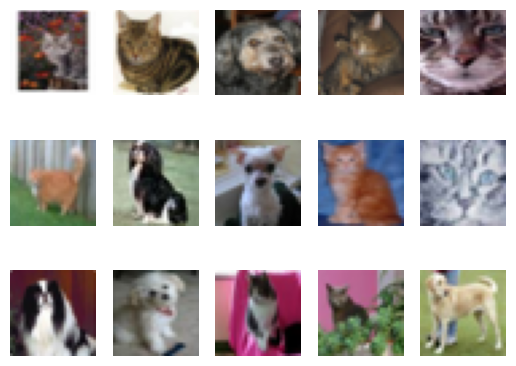

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print("There are", len(train_loader.sampler.indices), "training examples in training set.")
print("There are", len(val_loader.sampler.indices), "validation examples in validation set.")
print("There are", len(test_loader.sampler.indices), "test examples in testing set.")

There are 8000 training examples in training set.
There are 2000 validation examples in validation set.
There are 2000 test examples in testing set.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

Although the training set helps the model learn patterns, the validation set provides an unbiased evaluation of its performance on unseen data and helps tune hyperparameters. Without a validation set, we risk overfitting, where the model memorizes the training data instead of generalizing well. Judging performance solely on training error gives a misleading sense of accuracy, as the model may fail on real-world data. Validation accuracy provides a better estimate of how the model will perform on new inputs.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

print("-----------------------------")

for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
-----------------------------
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Total parameters in SmallNet:", sum(p.numel() for p in small_net.parameters()))
print("Total parameters in LargeNet:", sum(p.numel() for p in large_net.parameters()))

Total parameters in SmallNet: 386
Total parameters in LargeNet: 9705


There are 5x3x3x3 + 5 + 1x245 + 1 = 386 parameters in small_net. There are 5x3x5x5 + 5 + 10x5x5x5 + 10 + 32x250 + 32 + 1x32 + 1 = 9705
parameters in large_net.

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default values of the hyperparameters in the train_net function are:
- batch_size = 64
- learning_rate = 0.01
- num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.434875, Train loss: 0.6795997200012207 |Validation err: 0.3835, Validation loss: 0.6581949908286333
Epoch 2: Train err: 0.365625, Train loss: 0.6461632571220398 |Validation err: 0.366, Validation loss: 0.646722175180912
Epoch 3: Train err: 0.348375, Train loss: 0.6296104927062989 |Validation err: 0.3495, Validation loss: 0.6227022483944893
Epoch 4: Train err: 0.338125, Train loss: 0.6150993580818176 |Validation err: 0.372, Validation loss: 0.6295221950858831
Epoch 5: Train err: 0.323125, Train loss: 0.6028898568153381 |Validation err: 0.324, Validation loss: 0.6110397297888994
Finished Training
Total time elapsed: 20.71 seconds


5 files each represent the checkpoint of a epoch containing weights, are saved to disk:

model_small_bs64_lr0.01_epoch0 - epoch 0

model_small_bs64_lr0.01_epoch1 - epoch 1

model_small_bs64_lr0.01_epoch2 - epoch 2

model_small_bs64_lr0.01_epoch3 - epoch 3

model_small_bs64_lr0.01_epoch4 - epoch 4



4 files with error and loss after each epoch are also saved to disk:

model_small_bs64_lr0.01_epoch4_train_err.csv - training error

model_small_bs64_lr0.01_epoch4_train_loss.csv - training loss

model_small_bs64_lr0.01_epoch4_val_err.csv - validation error

model_small_bs64_lr0.01_epoch4_val_loss.csv - validation loss


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716740608216 |Validation err: 0.3865, Validation loss: 0.660299738869071
Epoch 2: Train err: 0.37325, Train loss: 0.6497629313468933 |Validation err: 0.3845, Validation loss: 0.6575995795428753
Epoch 3: Train err: 0.360125, Train loss: 0.6389007897377014 |Validation err: 0.3495, Validation loss: 0.6291371881961823
Epoch 4: Train err: 0.346375, Train loss: 0.6246497564315796 |Validation err: 0.356, Validation loss: 0.6221635770052671
Epoch 5: Train err: 0.334125, Train loss: 0.6154210748672485 |Validation err: 0.328, Validation loss: 0.618933217599988
Epoch 6: Train err: 0.31775, Train loss: 0.6036666023731232 |Validation err: 0.3385, Validation loss: 0.6093297032639384
Epoch 7: Train err: 0.315875, Train loss: 0.5944248065948486 |Validation err: 0.328, Validation loss: 0.5973024442791939
Epoch 8: Train err: 0.308125, Train loss: 0.5829446413516999 |Validation err:

The small_net took 135.76s to train and the large_net took 157.93s to train. The large_net took longer because it has more parameters than the small_net, so more parameters need to be updated during back propagation, leading to more calculation and gradient descent needed to be done.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Training curve for small_net:


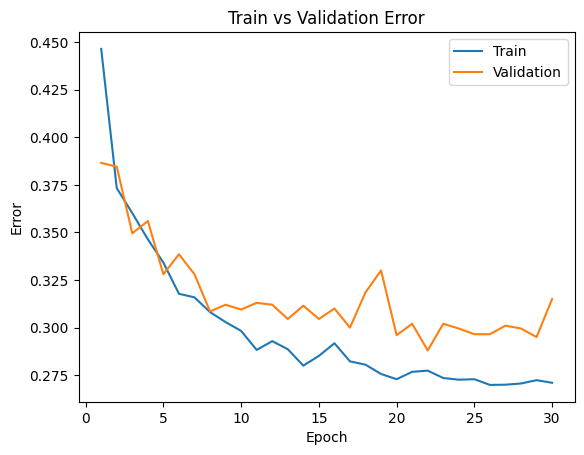

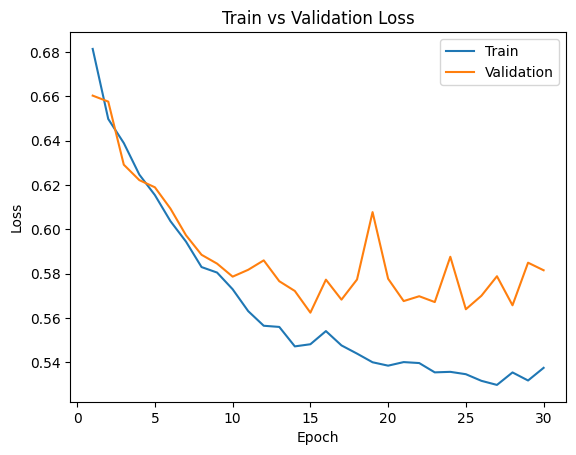

training curve for large_net:


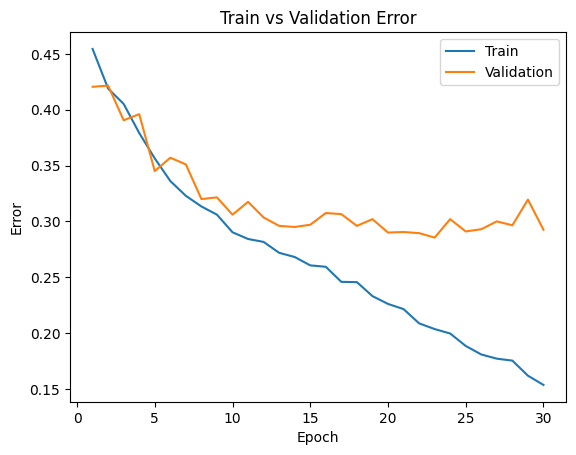

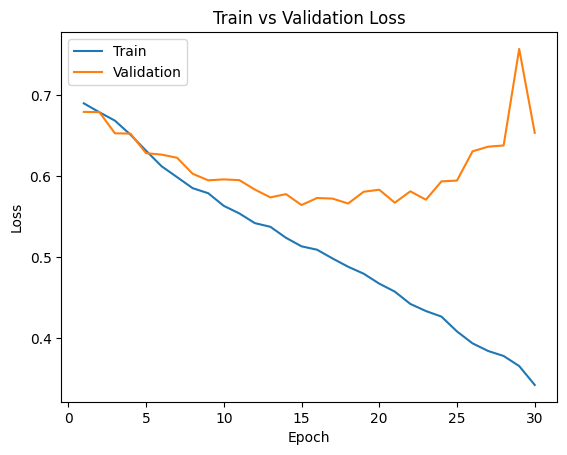

In [ ]:
print("Training curve for small_net:")
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)
print("training curve for large_net:")
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The SmallNet initially shows signs of underfitting, with both training and validation error decreasing as epochs increase. This underfitting becomes less prominent as the model continues training, leading to better performance by epoch 30.




The LargeNet follows a similar pattern at the beginning but starts to overfit around epoch 15. While its training loss continues to decrease, the validation loss begins to rise, indicating that the model is memorizing training data rather than generalizing well.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 

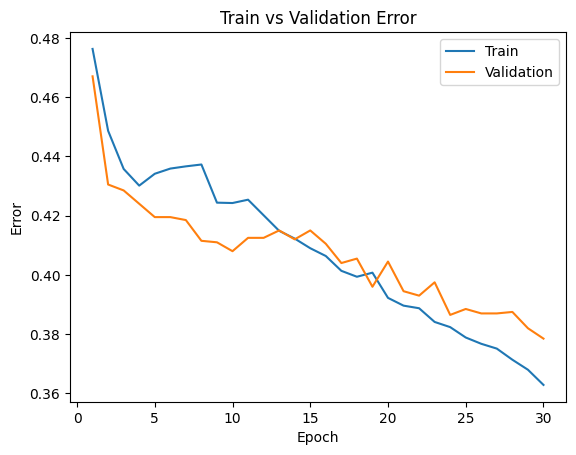

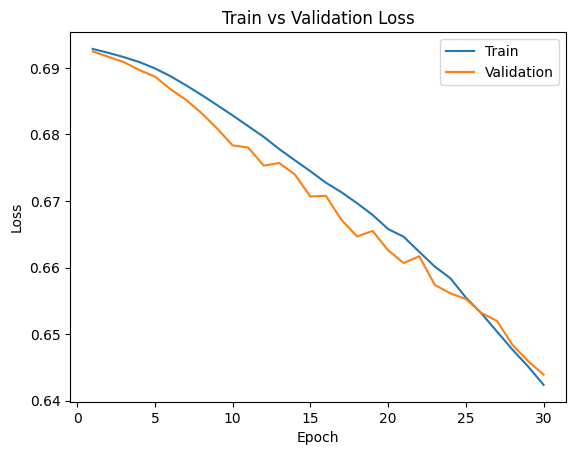

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

The model takes approximately the same time to train because lowering the learning rate only reduces the magnitude of parameter updates without affecting computational complexity. However, a lower learning rate results in a higher final training error and loss, as the model converges more slowly. The final validation error is also higher, but the validation loss decreases almost monotonically, indicating that overfitting is prevented. This suggests that while the model learns more gradually, it generalizes better by avoiding sharp fluctuations in validation performance. But the model does not reach the optimal zone (plateau), which is the sign of underfitting.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318,

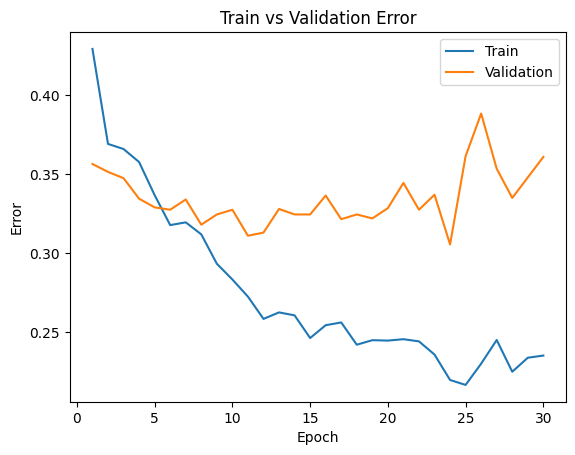

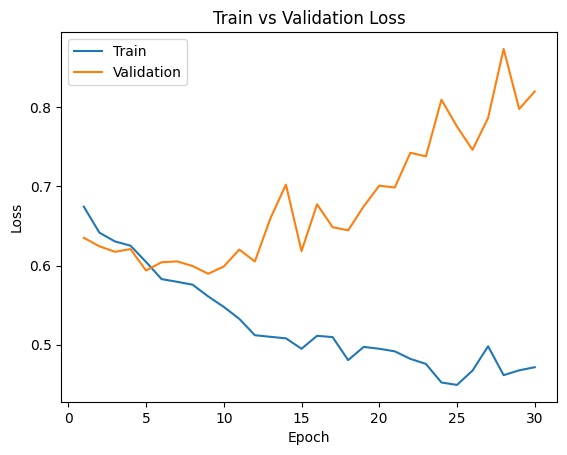

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

The model takes approximately the same time to train because lowering the learning rate only reduces the magnitude of parameter updates without affecting computational complexity. However, a higher learning rate leads to slightly higher final training error and loss, as the model updates weights more aggressively and may not settle into an optimal solution. The final validation error is also higher, and the validation loss starts fluctuating and bouncing back earlier, indicating that overfitting begins sooner. This suggests that while the model learns faster initially, it fails to generalize well and may struggle to converge to a stable minimum.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Val

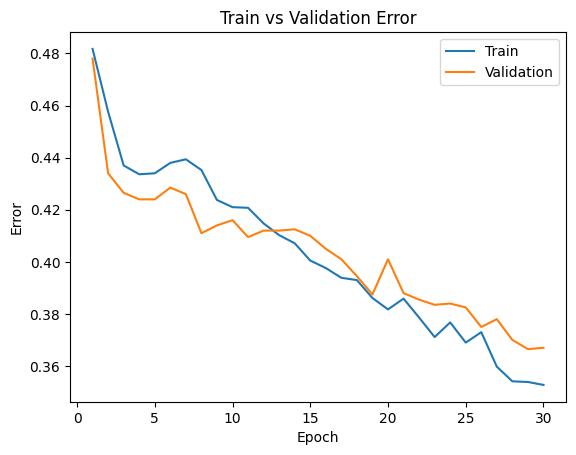

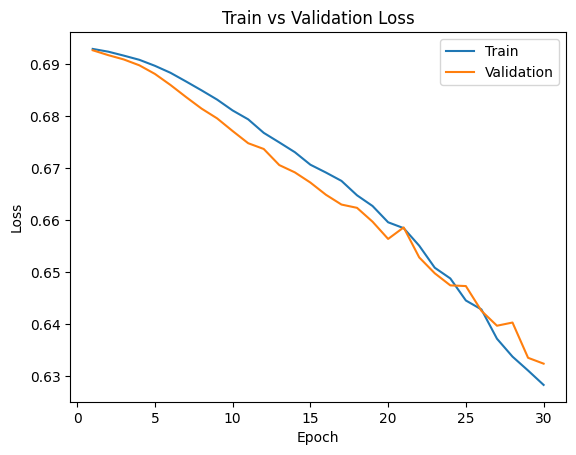

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

The model takes less time to train because a larger batch size reduces the number of iterations per epoch, leading to fewer weight updates and lower overall computation. However, increasing the batch size results in higher final training error and loss, as fewer updates make it harder for the model to fine-tune parameters. The final validation error is also higher, but the validation loss decreases almost monotonically, indicating that overfitting is prevented. This suggests that while training is more stable, the model may struggle to generalize as effectively due to fewer updates and reduced gradient noise.  But the model does not reach the optimal zone (plateau), which is the sign of underfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err:

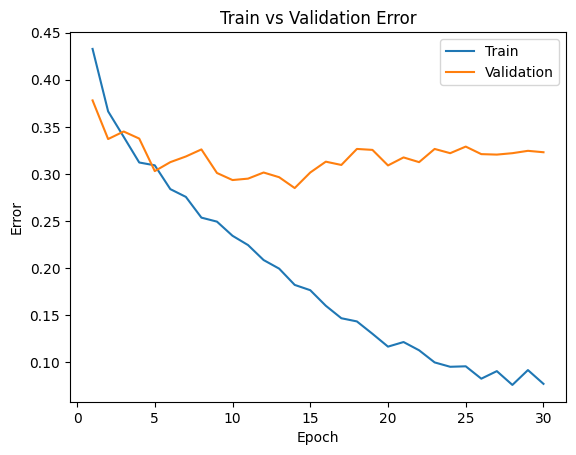

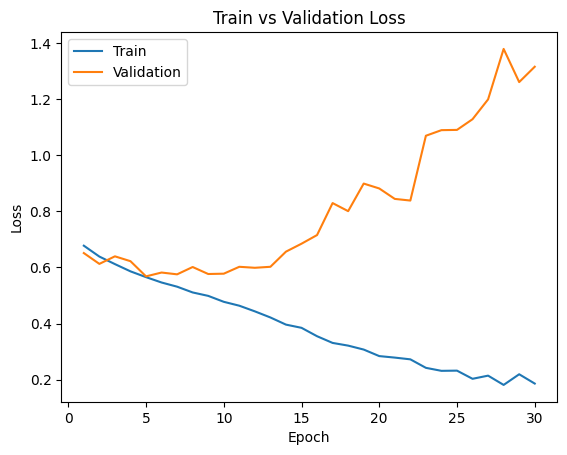

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

The model takes more time to train because decreasing the batch size increases the number of iterations per epoch, leading to more frequent weight updates and higher computational cost. A smaller batch size results in lower final training error and loss, as the model updates more frequently and fine-tunes better. However, the final validation error is slightly higher, and the validation loss starts bouncing back earlier, indicating that overfitting begins sooner. This suggests that while the model learns more effectively on the training data, it may struggle to generalize well to unseen data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I will use large_net because, in Part 2, we observed that small_net remained in the underfitting region throughout training and never reached the "optimal zone." Although large_net overfit with the default settings, adjusting other hyperparameters can help improve generalization. For the learning rate, a value of 0.01 led to overfitting, while 0.001 caused underfitting. I will use 0.005, a middle ground, to encourage better learning dynamics. For the batch size, 64 resulted in overfitting, while 512 led to underfitting. Choosing 256 balances the trade-off, aiming to land the model in the "optimal zone."

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477625, Train loss: 0.6928693596273661 |Validation err: 0.4685, Validation loss: 0.6925142854452133
Epoch 2: Train err: 0.451125, Train loss: 0.6922451816499233 |Validation err: 0.436, Validation loss: 0.6914755180478096
Epoch 3: Train err: 0.43525, Train loss: 0.6914684548974037 |Validation err: 0.4265, Validation loss: 0.690574586391449
Epoch 4: Train err: 0.42875, Train loss: 0.6903846431523561 |Validation err: 0.419, Validation loss: 0.6891278326511383
Epoch 5: Train err: 0.43725, Train loss: 0.6891164481639862 |Validation err: 0.4255, Validation loss: 0.6870567947626114
Epoch 6: Train err: 0.435125, Train loss: 0.6875725593417883 |Validation err: 0.423, Validation loss: 0.6847672164440155
Epoch 7: Train err: 0.4355, Train loss: 0.6857214942574501 |Validation err: 0.4175, Validation loss: 0.6822823286056519
Epoch 8: Train err: 0.431625, Train loss: 0.684075903147459 |Validation err: 0.

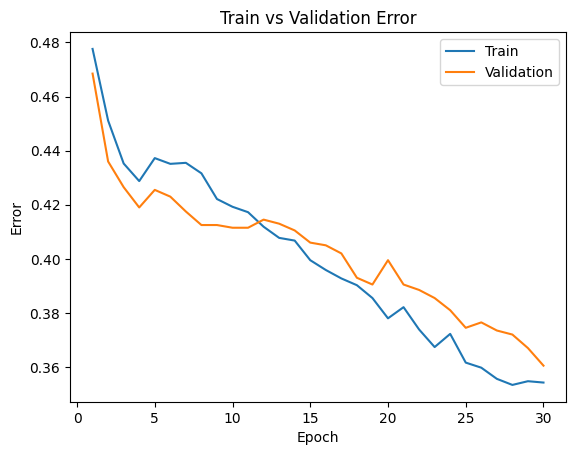

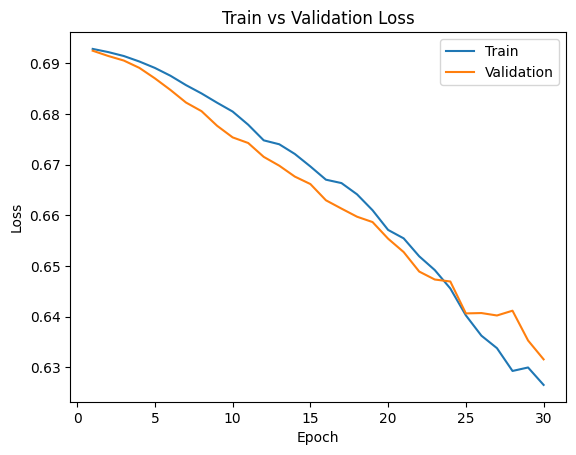

In [ ]:
large_net = LargeNet()
train_net(large_net, 256, 0.005, 30)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

We see that the model is underfitting all along. Thus, I will increase the number of epoch to 100 to try to land the model in the "optimal zone," and
keep other hyperparamerters the same.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477625, Train loss: 0.6928693596273661 |Validation err: 0.4685, Validation loss: 0.6925142854452133
Epoch 2: Train err: 0.451125, Train loss: 0.6922451816499233 |Validation err: 0.436, Validation loss: 0.6914755180478096
Epoch 3: Train err: 0.43525, Train loss: 0.6914684548974037 |Validation err: 0.4265, Validation loss: 0.690574586391449
Epoch 4: Train err: 0.42875, Train loss: 0.6903846431523561 |Validation err: 0.419, Validation loss: 0.6891278326511383
Epoch 5: Train err: 0.43725, Train loss: 0.6891164481639862 |Validation err: 0.4255, Validation loss: 0.6870567947626114
Epoch 6: Train err: 0.435125, Train loss: 0.6875725593417883 |Validation err: 0.423, Validation loss: 0.6847672164440155
Epoch 7: Train err: 0.4355, Train loss: 0.6857214942574501 |Validation err: 0.4175, Validation loss: 0.6822823286056519
Epoch 8: Train err: 0.431625, Train loss: 0.684075903147459 |Validation err: 0.

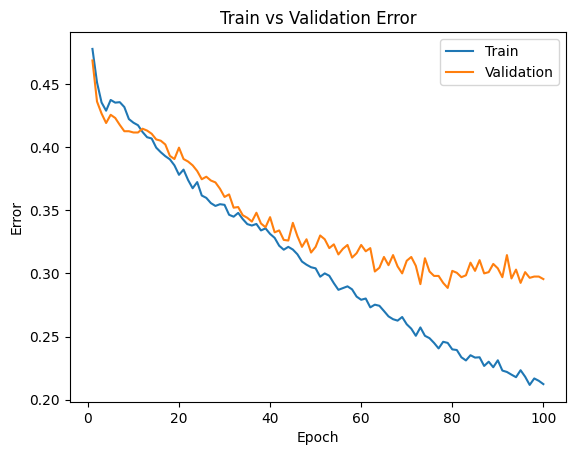

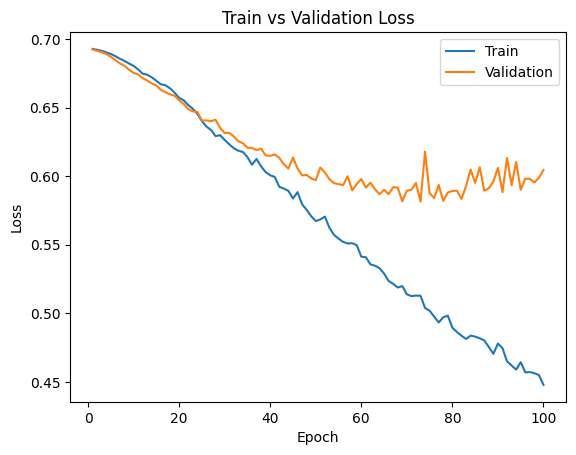

In [ ]:
large_net = LargeNet()
train_net(large_net, 256, 0.005, 100)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.005, epoch=99)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.005, epoch=78)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-25-86cf8e2adf45>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The model under the setting of large_net, batch_size=256, and learning_rate=0.005 performs the best at epoch 79 (epoch 79 in the training output, epoch 78 in the checkpoint file name), where it has the smallest validation error (0.2885) and validation loss (0.5881). The two values are both lower compared to those generated by the default hyperparameters in Section 2, Part D. The validation error and loss curves show a plateau around epoch 79, indicating that the model has likely reached the "optimal zone" where it is no longer overfitting or underfitting. This suggests that the chosen checkpoint successfully improved the model’s generalization and performance on unseen data.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("test classification error and loss:", test_err, test_loss)

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.285 0.5534288287162781


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test error (0.285) is slightly lower than the validation error (0.2885). However, the test error is expected to be higher than the validation error. This is because the validation set is used for hyperparameter tuning, making the model indirectly optimized for it, while the test set remains completely unseen. Additionally, the test set may contain slightly different distributions or challenging examples not present in the validation set. This small gap indicates that the model generalizes well but still experiences minor performance degradation on truly unseen data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only used the test dataset at the very end to ensure that it provides an unbiased estimate of the model’s true generalization performance. If we were to evaluate the test set frequently during training or hyperparameter tuning, we might unintentionally overfit to the test set, leading to overly optimistic results that do not reflect real-world performance. Keeping test usage minimal ensures that it remains a true measure of model performance on unseen data, helping us assess how well the model will generalize beyond the training process.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4385, Train loss: 0.6791962943971157 |Validation err: 0.4005, Validation loss: 0.6654459238052368
Epoch 2: Train err: 0.3925, Train loss: 0.6571448314934969 |Validation err: 0.395, Validation loss: 0.6559110432863235
Epoch 3: Train err: 0.37925, Train loss: 0.6470940951257944 |Validation err: 0.3875, Validation loss: 0.6521128639578819
Epoch 4: Train err: 0.369125, Train loss: 0.6390432920306921 |Validation err: 0.3845, Validation loss: 0.6493896022439003
Epoch 5: Train err: 0.3605, Train loss: 0.6324491780251265 |Validation err: 0.386, Validation loss: 0.6462259739637375
Epoch 6: Train err: 0.356875, Train loss: 0.6283854674547911 |Validation err: 0.3775, Validation loss: 0.6454341486096382
Epoch 7: Train err: 0.34475, Train loss: 0.622790364548564 |Validation err: 0.3805, Validation loss: 0.6446069926023483
Epoch 8: Train err: 0.339625, Train loss: 0.6187339574098587 |Validation err: 0.3

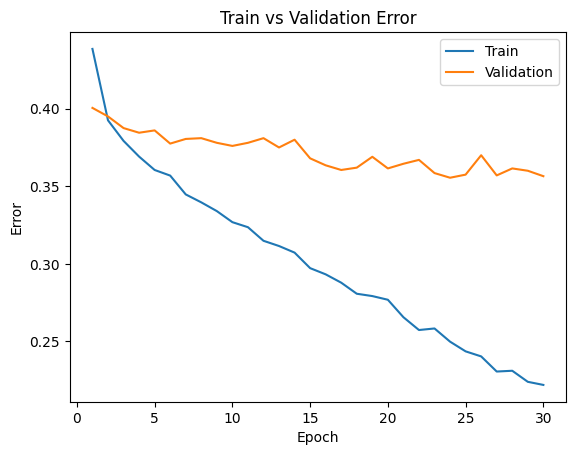

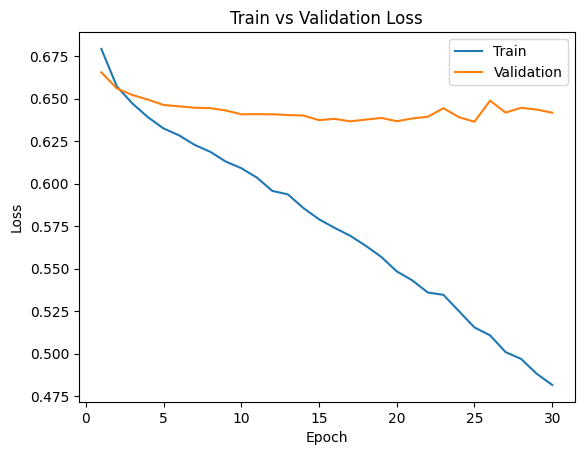

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.3435 0.636175662279129


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 128)
        self.layer2 = nn.Linear(128, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 32*32*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

ANN = Pigeon()
train_net(ANN, 256, 0.005, 30)
model_path_ANN = get_model_name("ANN", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_ANN)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size = 256)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN, test_loader, criterion)
print("test classification error and loss:", test_err, test_loss)

The ANN model has larger test error and loss compared with my best CNN model. Therefore, the CNN is better than ANN.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 19 image(s).
[NbConvertApp] Writing 1455627 bytes to /content/Lab2_Cats_vs_Dogs.html
